## imports

In [59]:
import requests
import pandas as pd
import numpy as np
import mysql.connector
import os

import sqlalchemy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar

In [60]:
import urllib.parse as urlparse
from urllib.parse import urlencode

In [61]:
polygon_api_key = os.getenv("QUANT_GALORE_POLYGON_API_KEY")
_POLYGON_V2_BASE_URL = "https://api.polygon.io/v2"
_POLYGON_V3_BASE_URL = "https://api.polygon.io/v3"

In [64]:
calendar = get_calendar("NYSE")
trading_dates = calendar.schedule(
    start_date = "2023-05-01", 
    end_date = "2024-07-02"
    #end_date = (datetime.today()-timedelta(days = 1))
).index.strftime("%Y-%m-%d").values

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/1965267071.py:2: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  trading_dates = calendar.schedule(
/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/1965267071.py:2: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  trading_dates = calendar.schedule(
/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/1965267071.py:2: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  trading_dates = calendar.schedule(


In [398]:
def add_params_to_url(url, params):
    url_parts = list(urlparse.urlparse(url))
    query = dict(urlparse.parse_qsl(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query)
    return urlparse.urlunparse(url_parts)

def add_default_ticker_params_to_polygon_url(url, additional_params = None):
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': '50000',
        'apiKey': polygon_api_key,
    }
    if additional_params is not None:
        params.update(additional_params)
    return add_params_to_url(url, params)

def add_default_options_params_to_polygon_url(url, additional_params = None):
    params = {
        'limit': '1000',
        'apiKey': polygon_api_key,
    }
    if additional_params is not None:
        params.update(additional_params)
    return add_params_to_url(url, params)

def get_polygon_range_query_url(ticker, date_str_begin, date_str_end):
    return add_default_ticker_params_to_polygon_url(f"{_POLYGON_V2_BASE_URL}/aggs/ticker/{ticker}/range/1/day/{date_str_begin}/{date_str_end}")

def get_polygon_intraday_query_url(ticker, date_str):
    return add_default_ticker_params_to_polygon_url(f"{_POLYGON_V2_BASE_URL}/aggs/ticker/{ticker}/range/1/minute/{date_str}/{date_str}")

def get_polygon_options_contracts_query_url(underlying_ticker, option_type, date_str, exp_date_str):
    params = {
        "underlying_ticker": underlying_ticker,
        "contract_type": option_type,
        "as_of": date_str,
    }
    if exp_date_str is not None:
        params["expiration_date"] = exp_date_str

    return add_default_options_params_to_polygon_url(f"{_POLYGON_V3_BASE_URL}/reference/options/contracts", additional_params = params)

def get_polygon_result_dict(url):
    js = requests.get(url).json()
    if "results" not in js:
        return {}
    return js["results"]

def polygon_result_to_dataframe(result):
    df = pd.json_normalize(result)
    if df.empty:
        return df
    if "t" in df.columns:
        df = df.set_index("t")
        df.index = pd.to_datetime(df.index, unit="ms", utc=True).tz_convert("America/New_York")
        #df['date'] = df.index.strftime('%Y-%m-%d')
    return df

def polygon_url_to_dataframe(url):
    return polygon_result_to_dataframe(get_polygon_result_dict(url))    

In [66]:
ticker_spy = "SPY"
ticker_spx = "I:SPX"
ticker_goog = "GOOG"
ticker_sbux = "SBUX"
ticker_vix1d = "I:VIX1D"
options_ticker = "SPX"

i = 2
date = trading_dates[i]
prior_day = trading_dates[i-1]

trade_list = []
times = []

## cache history daily data

### spy

In [ ]:
df_spy_daily_history = polygon_result_to_dataframe(get_polygon_result_dict(
    get_polygon_range_query_url(ticker_spy, "2020-01-01", trading_dates[-1])))
df_spy_daily_history.index = df_spy_daily_history.index.strftime("%Y-%m-%d")

In [ ]:
df_spy_daily_history.to_pickle('market_data/df_spy_daily_history.pkl')

### individual tickers

In [349]:
df_spx_daily_history = polygon_result_to_dataframe(get_polygon_result_dict(
    get_polygon_range_query_url(ticker_spx, "2020-01-01", trading_dates[-1])))
df_spx_daily_history.index = df_spx_daily_history.index.strftime("%Y-%m-%d")

In [350]:
df_spx_daily_history.to_pickle('market_data/df_spx_daily_history.pkl')

In [68]:
df_goog_daily_history = polygon_result_to_dataframe(get_polygon_result_dict(
    get_polygon_range_query_url(ticker_goog, "2020-01-01", trading_dates[-1])))
df_goog_daily_history.index = df_goog_daily_history.index.strftime("%Y-%m-%d")

In [69]:
df_goog_daily_history.to_pickle('market_data/df_goog_daily_history.pkl')

In [70]:
df_sbux_daily_history = polygon_result_to_dataframe(get_polygon_result_dict(
    get_polygon_range_query_url(ticker_sbux, "2020-01-01", trading_dates[-1])))
df_sbux_daily_history.index = df_sbux_daily_history.index.strftime("%Y-%m-%d")

In [71]:
df_sbux_daily_history.to_pickle('market_data/df_sbux_daily_history.pkl')

## cache history intraday data

In [74]:
def get_df_intrady_history(ticker):
    dfs = []
    for date in trading_dates[1:]:
        df_intraday = polygon_result_to_dataframe(get_polygon_result_dict(
            get_polygon_intraday_query_url(ticker, date)))
        dfs.append(df_intraday.reset_index())
    df = pd.concat(dfs, ignore_index=True).set_index("t")
    return df

### spy

In [ ]:
df_spy_intraday_history = get_df_intrady_history(ticker_spy)

In [ ]:
df_spy_intraday_history = df_spy_intraday_history.drop(columns=["index"])

In [ ]:
df_spy_intraday_history.to_pickle('market_data/df_spy_intraday_history.pkl')

### vix

In [ ]:
df_vix1d_intraday_history = get_df_intrady_history(ticker_vix1d)

In [ ]:
df_vix1d_intraday_history = df_vix1d_intraday_history.drop(columns=["index"])

In [ ]:
df_vix1d_intraday_history.to_pickle('market_data/df_vix1d_intraday_history.pkl')

### individual tickers

In [272]:
df_spx_intraday_history = get_df_intrady_history(ticker_spx)

date='2023-05-02'
date='2023-05-03'
date='2023-05-04'
date='2023-05-05'
date='2023-05-08'
date='2023-05-09'
date='2023-05-10'
date='2023-05-11'
date='2023-05-12'
date='2023-05-15'
date='2023-05-16'
date='2023-05-17'
date='2023-05-18'
date='2023-05-19'
date='2023-05-22'
date='2023-05-23'
date='2023-05-24'
date='2023-05-25'
date='2023-05-26'
date='2023-05-30'
date='2023-05-31'
date='2023-06-01'
date='2023-06-02'
date='2023-06-05'
date='2023-06-06'
date='2023-06-07'
date='2023-06-08'
date='2023-06-09'
date='2023-06-12'
date='2023-06-13'
date='2023-06-14'
date='2023-06-15'
date='2023-06-16'
date='2023-06-19'
date='2023-06-20'
date='2023-06-21'
date='2023-06-22'
date='2023-06-23'
date='2023-06-26'
date='2023-06-27'
date='2023-06-28'
date='2023-06-29'
date='2023-06-30'
date='2023-07-03'
date='2023-07-05'
date='2023-07-06'
date='2023-07-07'
date='2023-07-10'
date='2023-07-11'
date='2023-07-12'
date='2023-07-13'
date='2023-07-14'
date='2023-07-17'
date='2023-07-18'
date='2023-07-19'
date='2023

In [290]:
df_spx_intraday_history = df_spx_intraday_history.drop(columns=["index"])
df_spx_intraday_history.to_pickle('market_data/df_spx_intraday_history.pkl')

In [75]:
df_goog_intraday_history = get_df_intrady_history(ticker_goog)

In [76]:
df_goog_intraday_history = df_goog_intraday_history.drop(columns=["index"])
df_goog_intraday_history.to_pickle('market_data/df_goog_intraday_history.pkl')

In [77]:
df_sbux_intraday_history = get_df_intrady_history(ticker_sbux)

In [78]:
df_sbux_intraday_history = df_sbux_intraday_history.drop(columns=["index"])
df_sbux_intraday_history.to_pickle('market_data/df_sbux_intraday_history.pkl')

## read cached data

In [571]:
df_spy_daily_history = pd.read_pickle('market_data/df_spy_daily_history.pkl')

df_spx_daily_history = pd.read_pickle('market_data/df_spx_daily_history.pkl')
df_goog_daily_history = pd.read_pickle('market_data/df_goog_daily_history.pkl')
df_sbux_daily_history = pd.read_pickle('market_data/df_sbux_daily_history.pkl')

In [572]:
df_spy_intraday_history = pd.read_pickle('market_data/df_spy_intraday_history.pkl')
df_vix1d_intraday_history = pd.read_pickle('market_data/df_vix1d_intraday_history.pkl')

df_spx_intraday_history = pd.read_pickle('market_data/df_spx_intraday_history.pkl')
df_goog_intraday_history.to_pickle('market_data/df_goog_intraday_history.pkl')
df_sbux_intraday_history.to_pickle('market_data/df_sbux_intraday_history.pkl')

## logic

In [573]:
df_spy = df_spy_daily_history[["c"]].copy()

In [574]:
df_spy["1_mo_avg"] = df_spy["c"].rolling(window=20).mean()
df_spy["3_mo_avg"] = df_spy["c"].rolling(window=60).mean()
df_spy['regime'] = df_spy.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [575]:
def get_df_market_open_from_intraday(df_intraday):
    df_market_open = df_intraday[df_intraday.index.time >= pd.Timestamp("09:35").time()].head(1)[["c"]]
    df_market_open.index = df_market_open.index.strftime("%Y-%m-%d")     
    return df_market_open

def get_df_market_close_from_intraday(df_intraday):
    df_market_close = df_intraday.tail(1)[["c"]]
    df_market_close.index = df_market_close.index.strftime("%Y-%m-%d")
    return df_market_close

In [ ]:
def get_df_market_open_history_from_intraday_history(df_intraday_history):
    
    df_market_open = df_intraday[df_intraday.index.time >= pd.Timestamp("09:35").time()].head(1)[["c"]]
    df_market_open.index = df_market_open.index.strftime("%Y-%m-%d")     
    return df_market_open

def get_df_market_close_history_from_intraday_history(df_intraday_history):
    df_market_close = df_intraday.tail(1)[["c"]]
    df_market_close.index = df_market_close.index.strftime("%Y-%m-%d")
    return df_market_close

In [576]:
df_spy_market_open_history = get_df_market_open_from_intraday(df_spy_intraday_history)
df_vix1d_market_open_history = get_df_market_open_from_intraday(df_vix1d_intraday_history)
df_spx_market_open_history = get_df_market_open_from_intraday(df_spx_intraday_history)

TypeError: '>=' not supported between instances of 'NaTType' and 'datetime.time'

In [567]:
get_df_market_open_from_intraday(df_spx_intraday_history)

TypeError: '>=' not supported between instances of 'NaTType' and 'datetime.time'

In [566]:
df_spx_market_close_history = get_df_market_close_from_intraday(df_spx_intraday_history)

In [564]:
df_spx_market_close_history

,c
t,
2024-07-02,5509.01


In [565]:
df_spx_intraday_history

,o,c,h,l
t,,,,
2023-05-02 09:30:00-04:00,4164.10,4155.45,4164.10,4155.45
2023-05-02 09:31:00-04:00,4155.33,4152.71,4155.33,4152.41
2023-05-02 09:32:00-04:00,4152.69,4152.45,4153.43,4152.11
2023-05-02 09:33:00-04:00,4152.33,4152.54,4153.54,4152.30
2023-05-02 09:34:00-04:00,4152.47,4153.63,4153.75,4151.44
...,...,...,...,...
2024-07-02 15:57:00-04:00,5506.88,5507.27,5507.27,5504.98
2024-07-02 15:58:00-04:00,5507.24,5508.89,5509.11,5507.24
2024-07-02 15:59:00-04:00,5508.92,5509.28,5509.56,5507.55


In [164]:
df_goog_market_open_history = get_df_market_open_from_intraday(df_goog_intraday_history)
df_sbux_market_open_history = get_df_market_open_from_intraday(df_sbux_intraday_history)

In [20]:
#df_algo = df_spx_daily_history[["c"]].copy()
#df_algo = df_algo.join(df_spx_market_open_history, lsuffix="_daily", rsuffix="_market_open")

In [88]:
def get_df_daily_expectation(df_market_open_history):
    df_algo = df_market_open_history.add_suffix("_market_open").copy()
    df_algo['regime'] = df_spy['regime']
    df_algo["expected_move"] = (round(df_vix1d_market_open_history / np.sqrt(252), 2) / 100) * 0.5
    df_algo["lower_price"] = round(df_algo['c_market_open'] * (1.0 - df_algo['expected_move']), 2)
    df_algo["upper_price"] = round(df_algo['c_market_open'] * (1.0 + df_algo['expected_move']), 2)
    return df_algo

In [109]:
df_spx_daily_expectation = get_df_daily_expectation(df_spx_market_open_history)

In [560]:
df_spx_daily_expectation

,c_market_open,regime,expected_move,lower_price,upper_price
t,,,,,
2023-05-02,4153.26,-1,0.00300,4140.80,4165.72
2023-05-03,4125.70,-1,0.00600,4100.95,4150.45
2023-05-04,4081.20,-1,0.00465,4062.22,4100.18
2023-05-05,4104.23,1,0.00410,4087.40,4121.06
2023-05-08,4137.65,1,0.00320,4124.41,4150.89
...,...,...,...,...,...
2024-06-26,5457.73,1,0.00235,5444.90,5470.56
2024-06-27,5483.08,1,0.00240,5469.92,5496.24
2024-06-28,5496.61,1,0.00280,5481.22,5512.00


In [ ]:
df_spx_market_open_history

In [165]:
df_goog_daily_expectation = get_df_daily_expectation(df_goog_market_open_history)

In [199]:
df_goog_daily_expectation

,c_market_open,regime,expected_move,lower_price,upper_price
t,,,,,
2023-05-02,107.590,-1,0.00300,107.27,107.91
2023-05-03,106.300,-1,0.00600,105.66,106.94
2023-05-04,105.555,-1,0.00465,105.06,106.05
2023-05-05,105.255,1,0.00410,104.82,105.69
2023-05-08,106.650,1,0.00320,106.31,106.99
...,...,...,...,...,...
2024-06-26,184.630,1,0.00235,184.20,185.06
2024-06-27,186.650,1,0.00240,186.20,187.10
2024-06-28,184.450,1,0.00280,183.93,184.97


In [166]:
df_sbux_daily_expectation = get_df_daily_expectation(df_sbux_market_open_history)

## cache options data

In [300]:
def get_df_options_history(ticker, side):
    dfs = []
    for date in trading_dates[1:]:
        df = polygon_url_to_dataframe(get_polygon_options_contracts_query_url(
            ticker, side, date, date))
        df['date'] = date
        print(f"{date}\n{df.head(2)}")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    return df

In [14]:
df_spx_call_options_history = get_df_options_history("SPX", "call")
df_spx_put_options_history = get_df_options_history("SPX", "put")
df_spx_call_options_history.to_pickle('market_data/df_spx_call_options_history.pkl')
df_spx_put_options_history.to_pickle('market_data/df_spx_put_options_history.pkl')

In [82]:
df_goog_call_options_history = get_df_options_history(ticker_goog, "call")
df_goog_put_options_history = get_df_options_history(ticker_goog, "put")
df_goog_call_options_history.to_pickle('market_data/df_goog_call_options_history.pkl')
df_goog_put_options_history.to_pickle('market_data/df_goog_put_options_history.pkl')

In [83]:
df_sbux_call_options_history = get_df_options_history(ticker_sbux, "call")
df_sbux_put_options_history = get_df_options_history(ticker_sbux, "put")
df_sbux_call_options_history.to_pickle('market_data/df_sbux_call_options_history.pkl')
df_sbux_put_options_history.to_pickle('market_data/df_sbux_put_options_history.pkl')

## cache intraday options data

In [17]:
def concat_otm_short_long(df_otm_short, df_otm_long, o_or_c, option_type):
    df_otm_options = pd.concat([
        df_otm_short.add_suffix(f"_market_{o_or_c}_s_{option_type}"), 
        df_otm_long.add_suffix(f"_market_{o_or_c}_l_{option_type}")], axis = 1)
    df_otm_options[f"market_{o_or_c}_spread"] = df_otm_options[f"c_market_{o_or_c}_s_{option_type}"] - \
        df_otm_options[f"c_market_{o_or_c}_l_{option_type}"]
    return df_otm_options

In [318]:
def get_df_otm_options_spread(date_str, df_otm_options_history, option_type):
    df_otm_options_daily = df_otm_options_history[df_otm_options_history.expiration_date == date_str]
    if df_otm_options_daily.empty:
        return None

    if option_type == "call":
        otm_short_ticker = df_otm_options_daily.head(1).ticker.values[0]
        otm_long_ticker = df_otm_options_daily.head(2).tail(1).ticker.values[0]
    else:
        otm_short_ticker = df_otm_options_daily.tail(1).ticker.values[0]
        otm_long_ticker = df_otm_options_daily.tail(2).head(1).ticker.values[0]

    df_otm_short_option_intraday = polygon_url_to_dataframe(get_polygon_intraday_query_url(otm_short_ticker, date_str))
    df_otm_long_option_intraday = polygon_url_to_dataframe(get_polygon_intraday_query_url(otm_long_ticker, date_str))
    if df_otm_short_option_intraday.empty or df_otm_long_option_intraday.empty:
        return None
    
    df_otm_short_option_market_open = get_df_market_open_from_intraday(df_otm_short_option_intraday)
    df_otm_long_option_market_open = get_df_market_open_from_intraday(df_otm_long_option_intraday)
    df_otm_options_market_open = concat_otm_short_long(
        df_otm_short_option_market_open, df_otm_long_option_market_open,
        "o", option_type
    )

    df_otm_short_option_market_close = get_df_market_close_from_intraday(df_otm_short_option_intraday)
    df_otm_long_option_market_close = get_df_market_close_from_intraday(df_otm_long_option_intraday)
    df_otm_options_market_close = concat_otm_short_long(
        df_otm_short_option_market_close, df_otm_long_option_market_close,
        "c", option_type
    )    
    
    df_otm_options = df_otm_options_market_open.join(df_otm_options_market_close)
    df_otm_options["pnl"] = df_otm_options["market_o_spread"] - df_otm_options["market_c_spread"]

    return df_otm_options

In [281]:
def get_df_otm_options_spread_history(df_daily_expectation, df_options_history, option_type):
    df_otm_options_history = df_options_history.join(df_daily_expectation, on='expiration_date')
    if option_type == "call":
        df_otm_options_history = df_otm_options_history[
            df_otm_options_history.strike_price > df_otm_options_history.upper_price
        ]    
    else:
        df_otm_options_history = df_otm_options_history[
            df_otm_options_history.strike_price < df_otm_options_history.lower_price
        ]
    
    dfs = []
    for date in trading_dates[1:]:
        df_date = get_df_otm_options_spread(date, df_otm_options_history, option_type)
        if df_date is None:
            continue
        dfs.append(df_date)
    df = pd.concat(dfs, ignore_index=False)
    return df

In [ ]:
df_spx_otm_call_options_spread_history = get_df_otm_options_spread_history(df_spx_daily_expectation, df_spx_call_options_history, "call")

In [34]:
df_spx_otm_call_options_spread_history.to_pickle('market_data/df_spx_otm_call_options_spread_history.pkl')

In [38]:
df_spx_otm_put_options_spread_history = get_df_otm_options_spread_history(df_spx_daily_expectation, df_spx_put_options_history, "put")

In [39]:
df_spx_otm_put_options_spread_history.to_pickle('market_data/df_spx_otm_put_options_spread_history.pkl')

In [283]:
df_daily_expectation = df_goog_daily_expectation.copy()
df_options_history = df_goog_call_options_history.copy()
df_otm_options_history = df_options_history.join(df_daily_expectation, on='expiration_date')
option_type = "call"
if option_type == "call":
    df_otm_options_history = df_otm_options_history[
        df_otm_options_history.strike_price > df_otm_options_history.upper_price
    ]    
else:
    df_otm_options_history = df_otm_options_history[
        df_otm_options_history.strike_price < df_otm_options_history.lower_price
    ]


In [319]:
df_goog_otm_call_options_spread_history = get_df_otm_options_spread_history(df_goog_daily_expectation, df_goog_call_options_history, "call")


KeyboardInterrupt



In [244]:
df_goog_otm_call_options_spread_history.to_pickle('market_data/df_goog_otm_call_options_spread_history.pkl')

In [245]:
df_goog_otm_put_options_spread_history = get_df_otm_options_spread_history(df_goog_daily_expectation, df_goog_put_options_history, "put")

In [246]:
df_goog_otm_put_options_spread_history.to_pickle('market_data/df_goog_otm_put_options_spread_history.pkl')

In [247]:
df_sbux_otm_call_options_spread_history = get_df_otm_options_spread_history(df_sbux_daily_expectation, df_sbux_call_options_history, "call")

In [248]:
df_sbux_otm_call_options_spread_history.to_pickle('market_data/df_sbux_otm_call_options_spread_history.pkl')

In [249]:
df_sbux_otm_put_options_spread_history = get_df_otm_options_spread_history(df_sbux_daily_expectation, df_sbux_put_options_history, "put")

In [250]:
df_sbux_otm_put_options_spread_history.to_pickle('market_data/df_sbux_otm_put_options_spread_history.pkl')

## read cached options data

In [ ]:
df_spx_call_options_history = pd.read_pickle('market_data/df_spx_call_options_history.pkl')
df_spx_put_options_history = pd.read_pickle('market_data/df_spx_put_options_history.pkl')

In [ ]:
df_spx_otm_call_options_spread_history = pd.read_pickle('market_data/df_spx_otm_call_options_spread_history.pkl')
df_spx_otm_put_options_spread_history = pd.read_pickle('market_data/df_spx_otm_put_options_spread_history.pkl')

In [ ]:
df_goog_call_options_history = pd.read_pickle('market_data/df_goog_call_options_history.pkl')
df_goog_put_options_history = pd.read_pickle('market_data/df_goog_put_options_history.pkl')

In [ ]:
df_goog_otm_call_options_spread_history = pd.read_pickle('market_data/df_goog_otm_call_options_spread_history.pkl')
df_goog_otm_put_options_spread_history = pd.read_pickle('market_data/df_goog_otm_put_options_spread_history.pkl')

In [ ]:
df_sbux_call_options_history = pd.read_pickle('market_data/df_sbux_call_options_history.pkl')
df_sbux_put_options_history = pd.read_pickle('market_data/df_sbux_put_options_history.pkl')

In [ ]:
df_sbux_otm_call_options_spread_history = pd.read_pickle('market_data/df_sbux_otm_call_options_spread_history.pkl')
df_sbux_otm_put_options_spread_history = pd.read_pickle('market_data/df_sbux_otm_put_options_spread_history.pkl')

## logic with options data

In [154]:
df_spx_algo = df_spx_daily_expectation.join(df_spx_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_spx_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_spx_algo['pnl_c_n_reg'] = np.where(df_spx_algo.regime < 0, df_spx_algo.pnl_call, 0)
df_spx_algo['pnl_p_p_reg'] = np.where(df_spx_algo.regime > 0, df_spx_algo.pnl_put, 0)

In [392]:
df_spx_algo

,c_market_open,regime,expected_move,lower_price,upper_price,pnl_call,pnl_put,pnl_c_n_reg,pnl_p_p_reg
t,,,,,,,,,
2023-05-02,4153.26,-1,0.00300,4140.80,4165.72,0.90,-2.16,0.90,0.00
2023-05-03,4125.70,-1,0.00600,4100.95,4150.45,1.31,-3.62,1.31,0.00
2023-05-04,4081.20,-1,0.00465,4062.22,4100.18,1.10,1.08,1.10,0.00
2023-05-05,4104.23,1,0.00410,4087.40,4121.06,-5.85,1.10,0.00,1.10
2023-05-08,4137.65,1,0.00320,4124.41,4150.89,0.83,0.85,0.00,0.85
...,...,...,...,...,...,...,...,...,...
2024-06-26,5457.73,1,0.00235,5444.90,5470.56,-2.13,0.90,0.00,0.90
2024-06-27,5483.08,1,0.00240,5469.92,5496.24,1.10,0.84,0.00,0.84
2024-06-28,5496.61,1,0.00280,5481.22,5512.00,1.25,-3.76,0.00,-3.76


<AxesSubplot:xlabel='t'>

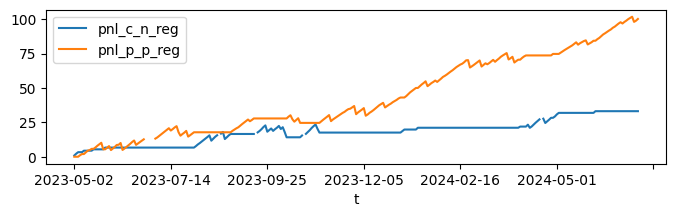

In [390]:
df_spx_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [388]:
df_spx_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,33.14,-74.90
1,-54.36,100.26


In [157]:
df_spx_otm_call_options_spread_history[
    df_spx_algo["regime"] < 0
].sum()

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/2214457600.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_call_options_spread_history[


c_market_o_s_call    323.67
c_market_o_l_call    239.52
market_o_spread       84.15
c_market_c_s_call    196.58
c_market_c_l_call    145.57
market_c_spread       51.01
pnl                   33.14
dtype: float64

In [158]:
df_spx_otm_call_options_spread_history.sum()

c_market_o_s_call    1047.16
c_market_o_l_call     732.10
market_o_spread       315.06
c_market_c_s_call    1132.63
c_market_c_l_call     796.35
market_c_spread       336.28
pnl                   -21.22
dtype: float64

In [159]:
df_spx_otm_put_options_spread_history[
    df_spx_algo["regime"] > 0
].sum()

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/465159656.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_put_options_spread_history[


c_market_o_s_put    896.91
c_market_o_l_put    668.93
market_o_spread     227.98
c_market_c_s_put    478.88
c_market_c_l_put    351.16
market_c_spread     127.72
pnl                 100.26
dtype: float64

In [160]:
df_spx_otm_put_options_spread_history.sum()

c_market_o_s_put    1306.32
c_market_o_l_put     997.03
market_o_spread      309.29
c_market_c_s_put    1205.80
c_market_c_l_put     921.87
market_c_spread      283.93
pnl                   25.36
dtype: float64

In [394]:
df_goog_algo = df_goog_daily_expectation.join(df_goog_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_goog_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_goog_algo['pnl_c_n_reg'] = np.where(df_goog_algo.regime < 0, df_goog_algo.pnl_call, 0)
df_goog_algo['pnl_p_p_reg'] = np.where(df_goog_algo.regime > 0, df_goog_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

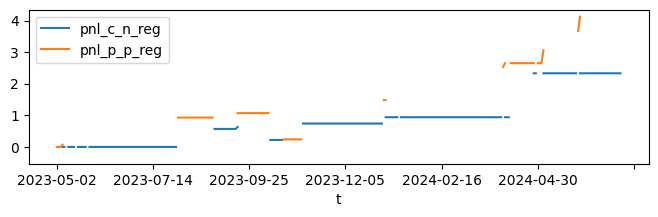

In [395]:
df_goog_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [259]:
df_goog_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,2.33,0.86
1,2.63,3.39


In [396]:
df_sbux_algo = df_sbux_daily_expectation.join(df_sbux_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_sbux_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_sbux_algo['pnl_c_n_reg'] = np.where(df_sbux_algo.regime < 0, df_sbux_algo.pnl_call, 0)
df_sbux_algo['pnl_p_p_reg'] = np.where(df_sbux_algo.regime > 0, df_sbux_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

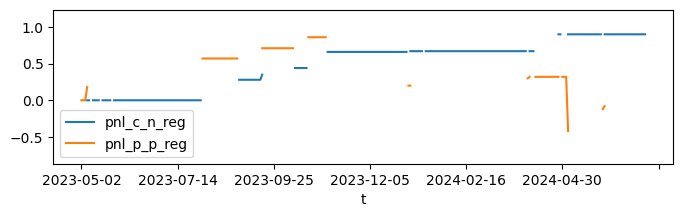

In [397]:
df_sbux_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [264]:
df_sbux_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,0.90,-0.54
1,-0.14,-0.66


## volatility calc

In [324]:
import scipy.optimize as optimize
import math

from scipy.stats import norm
from datetime import datetime, timedelta

In [538]:
def black_scholes(option_type, S, K, t, r, q, sigma):
    """
    Calculate the Black-Scholes option price.

    :param option_type: 'call' for call option, 'put' for put option.
    :param S: Current stock price.
    :param K: Strike price.
    :param t: Time to expiration (in years).
    :param r: Risk-free interest rate (annualized).
    :param q: Dividend yield (annualized).
    :param sigma: Stock price volatility (annualized).

    :return: Option price.
    """
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)

    if option_type == 'call':
        return S * math.exp(-q * t) * norm.cdf(d1) - K * math.exp(-r * t) * norm.cdf(d2)
    elif option_type == 'put':
        return K * math.exp(-r * t) * norm.cdf(-d2) - S * math.exp(-q * t) * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be either 'call' or 'put'.")
        
def call_implied_vol(S, K, t, r, option_price):
    q = 0.01
    option_type = "call"

    def f_call(sigma):
        return black_scholes(option_type, S, K, t, r, q, sigma) - option_price

    call_newton_vol = optimize.newton(f_call, x0=0.50, tol=0.05, maxiter=100)
    return call_newton_vol

def put_implied_vol(S, K, t, r, option_price):
    q = 0.01
    option_type = "put"

    def f_put(sigma):
        return black_scholes(option_type, S, K, t, r, q, sigma) - option_price

    put_newton_vol = optimize.newton(f_put, x0=0.50, tol=0.05, maxiter=100)
    return put_newton_vol



In [551]:
def get_atm_call_volatility(ticker, as_of_date):
    quote_timestamp = (pd.to_datetime(as_of_date).tz_localize("America/New_York") + timedelta(hours = 15, minutes = 55)).value
    close_timestamp = (pd.to_datetime(as_of_date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value    
    
    calls = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=call&as_of={as_of_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
    calls["days_to_exp"] = (pd.to_datetime(calls["expiration_date"]) - pd.to_datetime(as_of_date)).dt.days
    #calls = calls[calls["days_to_exp"] >= 5].copy()
    nearest_exp_date = calls["expiration_date"].iloc[0]
    calls = calls[calls["expiration_date"] == nearest_exp_date].copy()
    
    df_intraday = polygon_result_to_dataframe(get_polygon_result_dict(
        get_polygon_intraday_query_url(ticker, as_of_date)))    
    df_market_open_from_intraday = get_df_market_open_from_intraday(df_intraday)
    price = df_market_open_from_intraday.loc[as_of_date].c
    
    calls["distance_from_price"] = abs(round(((calls["strike_price"] - price) / price)*100, 2))

    atm_call = calls.nsmallest(1, "distance_from_price")
    call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"])
    call_quotes = call_quotes.set_index("sip_timestamp")
    call_quotes.index = pd.to_datetime(call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
    call_quotes["mid_price"] = round((call_quotes["bid_price"] + call_quotes["ask_price"]) / 2, 2)    
    
    time_to_expiration = atm_call.days_to_exp.values[0] / 252
    atm_call_vol = call_implied_vol(S=price, K=atm_call["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=call_quotes["mid_price"].iloc[0])
    
    return atm_call_vol

In [552]:
def get_atm_put_volatility(ticker, as_of_date):
    quote_timestamp = (pd.to_datetime(as_of_date).tz_localize("America/New_York") + timedelta(hours = 15, minutes = 55)).value
    close_timestamp = (pd.to_datetime(as_of_date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value    
    
    puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={as_of_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
    puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(as_of_date)).dt.days
    nearest_exp_date = puts["expiration_date"].iloc[0]
    puts = puts[puts["expiration_date"] == nearest_exp_date].copy()

    df_intraday = polygon_result_to_dataframe(get_polygon_result_dict(
        get_polygon_intraday_query_url(ticker, as_of_date)))    
    df_market_open_from_intraday = get_df_market_open_from_intraday(df_intraday)
    price = df_market_open_from_intraday.loc[as_of_date].c
    
    puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))
    
    atm_put = puts.nsmallest(1, "distance_from_price")

    put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
    put_quotes.index = pd.to_datetime(put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
    put_quotes["mid_price"] = round((put_quotes["bid_price"] + put_quotes["ask_price"]) / 2, 2)    
    
    time_to_expiration = atm_call.days_to_exp.values[0] / 252
    atm_put_vol = put_implied_vol(S=price, K=atm_put["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=put_quotes["mid_price"].iloc[0])    
    
    return atm_put_vol

In [553]:
def get_atm_volatility(ticker, as_of_date):
    atm_call_vol = get_atm_call_volatility(ticker, as_of_date)
    atm_put_vol = get_atm_put_volatility(ticker, as_of_date)
    atm_vol = round(((atm_call_vol + atm_put_vol) / 2)*100, 2)
    return atm_vol

In [557]:
def get_df_atm_vol_history(ticker):
    atm_call_vols = []
    dates = []
    for date in trading_dates[1:5]:
        try:
            atm_call_vol = get_atm_call_volatility(ticker, date)
        except Exception as ex:
            continue
        
        atm_call_vols.append(atm_call_vol)
        dates.append(date)
    df = pd.DataFrame({"atm_call_vol": atm_call_vols, "date": dates}).set_index("date")
    return df

In [558]:
pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/O:GOOG230505C00108000?timestamp.gte=1683057300000000000&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).sort_values("sip_timestamp")

,ask_exchange,ask_price,ask_size,bid_exchange,bid_price,bid_size,sequence_number,sip_timestamp
99,322,0.02,215,322,0.01,797,543169870,1683299709815101952
98,322,0.02,216,322,0.01,797,543172112,1683299709840332032
97,322,0.02,216,322,0.01,765,543194103,1683299710076660736
96,315,0.01,171,319,0.00,0,555865198,1683299940469775360
95,322,0.01,209,316,0.00,0,560792565,1683300015520428800
...,...,...,...,...,...,...,...,...
4,313,0.01,651,325,0.00,0,1386656538,1683316744345693440
3,313,0.01,651,319,0.00,0,1387492911,1683316754499890176
2,313,0.01,664,300,0.00,0,1389358650,1683316775188092160
1,313,0.01,589,301,0.00,0,1390834328,1683316789284304384


In [559]:
get_df_atm_vol_history(ticker)

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/247806508.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * math.sqrt(t))


,atm_call_vol
date,
2023-05-02,0.126841
2023-05-03,0.245509
2023-05-04,0.206451


In [328]:
ticker = "GOOG"
date = "2024-06-11"
quote_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 15, minutes = 55)).value
close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value

In [347]:
price = df_goog_market_open_history.loc[date].c

In [423]:
calls = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=call&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [424]:
calls["days_to_exp"] = (pd.to_datetime(calls["expiration_date"]) - pd.to_datetime(date)).dt.days
#calls = calls[calls["days_to_exp"] >= 5].copy()
nearest_exp_date = calls["expiration_date"].iloc[0]
calls = calls[calls["expiration_date"] == nearest_exp_date].copy()

In [425]:
nearest_exp_date

'2024-06-14'

In [426]:
calls["distance_from_price"] = abs(round(((calls["strike_price"] - price) / price)*100, 2))

In [444]:
calls.head()

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
0,OCASPS,call,american,2024-06-14,BATO,100,85.0,O:GOOG240614C00085000,GOOG,3,52.15
1,OCASPS,call,american,2024-06-14,BATO,100,90.0,O:GOOG240614C00090000,GOOG,3,49.34
2,OCASPS,call,american,2024-06-14,BATO,100,95.0,O:GOOG240614C00095000,GOOG,3,46.52
3,OCASPS,call,american,2024-06-14,BATO,100,100.0,O:GOOG240614C00100000,GOOG,3,43.71
4,OCASPS,call,american,2024-06-14,BATO,100,105.0,O:GOOG240614C00105000,GOOG,3,40.89


In [428]:
atm_call = calls.nsmallest(1, "distance_from_price")

In [429]:
atm_call

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OCASPS,call,american,2024-06-14,BATO,100,177.5,O:GOOG240614C00177500,GOOG,3,0.08


In [430]:
call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
call_quotes.index = pd.to_datetime(call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
call_quotes["mid_price"] = round((call_quotes["bid_price"] + call_quotes["ask_price"]) / 2, 2)

In [432]:
time_to_expiration = atm_call.days_to_exp.values[0] / 252

In [433]:
atm_call_vol = call_implied_vol(S=price, K=atm_call["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=call_quotes["mid_price"].iloc[0])

In [434]:
atm_call_vol

0.240868986287512

In [ ]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))
atm_put = puts.nsmallest(1, "distance_from_price")

In [435]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [436]:
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()

In [437]:
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))

In [438]:
atm_put = puts.nsmallest(1, "distance_from_price")

In [439]:
atm_put

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OPASPS,put,american,2024-06-14,BATO,100,177.5,O:GOOG240614P00177500,GOOG,3,0.08


In [440]:
put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
put_quotes.index = pd.to_datetime(put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
put_quotes["mid_price"] = round((put_quotes["bid_price"] + put_quotes["ask_price"]) / 2, 2)

In [441]:
atm_put_vol = put_implied_vol(S=price, K=atm_put["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=put_quotes["mid_price"].iloc[0])

In [442]:
atm_put_vol

0.1921287338318709

In [443]:
atm_vol = round(((atm_call_vol + atm_put_vol) / 2)*100, 2)
expected_move = (round((atm_vol / np.sqrt(252)), 2))

In [ ]:

end_time = datetime.now()
seconds_to_complete = (end_time - start_time).total_seconds()
times.append(seconds_to_complete)
iteration = round((np.where(trading_dates==date)[0][0]/len(trading_dates))*100,2)
iterations_remaining = len(trading_dates) - np.where(trading_dates==date)[0][0]
average_time_to_complete = np.mean(times)
estimated_completion_time = (datetime.now() + timedelta(seconds = int(average_time_to_complete*iterations_remaining)))
time_remaining = estimated_completion_time - datetime.now()
print(f"{iteration}% complete, {time_remaining} left, ETA: {estimated_completion_time}")
